In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch

from models import modelA

from tqdm.notebook import tqdm

import warnings
import pickle
import time
import multiprocess as mp

from sklearn.preprocessing import scale
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV

## Device setting

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Function Def

In [3]:
def get_mc_predictions(model, X, nb_iter=50, batch_size=256):
    model.train()
    output_dim = list(model.children())[-1].out_features
#     output_dim = list(model.children())[-1][-1].out_features # this line is for 3-channel image datasets
    get_output = lambda data : F.softmax(model(data))
#     get_output = lambda data : model(data)
    X = torch.Tensor(X).to(device)
    
    def predict():
        n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
        output = np.zeros(shape=(len(X), output_dim))
        for i in range(n_batches):
            output[i * batch_size:(i + 1) * batch_size] = get_output(X[i * batch_size:(i + 1) * batch_size]).detach().cpu().numpy()
        return output

    preds_mc = []
    for i in tqdm(range(nb_iter)):
        preds_mc.append(predict())

    return np.asarray(preds_mc)

In [4]:
def get_deep_representations(model, X, batch_size=256):
    model.eval()
    X = torch.Tensor(X).to(device)
    # mnist modelA last hidden layer 
    last_hidden_idx = -3
    output_dim = list(model.children())[last_hidden_idx].out_features

    last_hidden_output = None

    def last_hidden_hook(module, input_, output):
        nonlocal last_hidden_output
        last_hidden_output = output
    
    list(model.children())[last_hidden_idx].register_forward_hook(last_hidden_hook)

    n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
    output = np.zeros(shape=(len(X), output_dim))
    for i in tqdm(range(n_batches)):
        model(X[i * batch_size:(i + 1) * batch_size])
        output[i * batch_size:(i + 1) * batch_size] = last_hidden_output.detach().cpu().numpy()
    return output

In [5]:
def score_point(tup):
    x, kde = tup
    return kde.score_samples(np.reshape(x, (1, -1)))[0]

def score_samples(kdes, samples, preds, n_jobs=None):
    if n_jobs is not None:
        p = mp.Pool(n_jobs)
    else:
        p = mp.Pool()
    
    results = p.map(score_point, [(x, kdes[i]) for x, i in zip(samples, preds)])
    p.close()
    p.join()

    return results

def normalize(normal, adv):
    n_samples = len(normal)
    total = scale(np.concatenate((normal, adv)))

    return total[:n_samples], total[n_samples:]

def load_list(path):
    with open(path, "rb") as fp:   # Unpickling
        b = pickle.load(fp)
        return b

In [6]:
def train_LR(densities_pos, densities_neg, uncerts_pos, uncerts_neg):
    values_neg = np.concatenate(
        (densities_neg.reshape((1, -1)),
         uncerts_neg.reshape((1, -1))),
        axis=0).transpose([1, 0])
    values_pos = np.concatenate(
        (densities_pos.reshape((1, -1)),
         uncerts_pos.reshape((1, -1))),
        axis=0).transpose([1, 0])

    values = np.concatenate((values_neg, values_pos))
    labels = np.concatenate(
        (np.zeros_like(densities_neg), np.ones_like(densities_pos)))

    lr = LogisticRegressionCV(n_jobs=-1).fit(values, labels)

    return values, labels, lr

In [7]:
def compute_roc(probs_neg, probs_pos, labels, plot=True):
    """
    TODO
    :param probs_neg:
    :param probs_pos:
    :param plot:
    :return:
    """
    probs = np.concatenate((probs_neg, probs_pos))
    labels = np.concatenate((np.zeros_like(probs_neg), np.ones_like(probs_pos)))
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = auc(fpr, tpr)
    if plot:
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                 label='ROC (AUC = %0.4f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
        plt.legend(loc='lower right')
        plt.title("ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return fpr, tpr, auc_score

## Load MNIST Dataset

In [8]:
X_train_path = './example_data/mnist/org/mnist_org_train_24000.pkl'
X_test_path = './example_data/mnist/org/mnist_org_test_6000.pkl'

X_train_adv_path = './example_data/mnist/fgsm/mnist_fgsm_train_8000.pkl'
X_test_adv_path = './example_data/mnist/fgsm/mnist_fgsm_test_2000.pkl'

In [9]:
X_train, Y_train = load_list(X_train_path)[0].reshape(-1, 1, 28, 28), load_list(X_train_path)[1]
X_test, Y_test = load_list(X_test_path)[0].reshape(-1, 1, 28, 28), load_list(X_test_path)[1]

In [10]:
X_train_adv, Y_train_adv = load_list(X_train_adv_path)[0].reshape(-1, 1, 28, 28), load_list(X_train_adv_path)[1]
X_test_adv, Y_test_adv = load_list(X_test_adv_path)[0].reshape(-1, 1, 28, 28), load_list(X_test_adv_path)[1]

In [11]:
batch_size = 100

# Gaussian kernel bandwidth for kernel density estimation
# Authors set this value manually
BANDWIDTHS = {'mnist': 1.20, 'cifar': 0.26}

## Load pretrained model

In [14]:
model = modelA()
checkpoint = torch.load('./weights/modelA.pkl', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint, )
model.eval()
model.to(device)

modelA(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=25600, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Check Normal Accuracy of Pretrained Model

In [15]:
preds_train_normal = np.array([])
preds_test_normal = np.array([])

for s_type, dset in zip(['normal train', 'normal test'], [[X_train, Y_train], [X_test, Y_test]]):
    model.eval()
    
    dset = TensorDataset(torch.Tensor(dset[0].reshape(-1, 1, 28, 28)), torch.Tensor(dset[1]))    
    dset_loader = DataLoader(dset, batch_size=batch_size, shuffle=False, num_workers=10)
        
    correct = 0
    for data, target in dset_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, 1)
        
        if s_type == 'normal train':
            preds_train_normal = np.append(preds_train_normal, pred.tolist())
        else:
            preds_test_normal = np.append(preds_test_normal, pred.tolist())

        correct += (pred.detach().cpu().numpy() == target.cpu().numpy()).sum()
        
    acc = correct / len(dset)
    
    print("Model accuracy on the %s set: %0.2f%%" % (s_type, 100 * acc))
    
preds_train_normal = preds_train_normal.astype('int')
preds_test_normal = preds_test_normal.astype('int')

Model accuracy on the normal train set: 100.00%
Model accuracy on the normal test set: 100.00%


## Check Adversarial Accuracy of Pretrained Model

In [16]:
preds_train_adv = np.array([])
preds_test_adv = np.array([])

for s_type, dset in zip(['Adversarial train', 'Adversarial test'], [[X_train_adv, Y_train_adv], [X_test_adv, Y_test_adv]]):
    model.eval()
    
    dset = TensorDataset(torch.Tensor(dset[0].reshape(-1, 1, 28, 28)), torch.Tensor(dset[1]))    
    dset_loader = DataLoader(dset, batch_size=batch_size, shuffle=False, num_workers=10)
        
    correct = 0
    for data, target in dset_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = torch.argmax(output, 1)
        
        if s_type == 'Adversarial train':
            preds_train_adv = np.append(preds_train_adv, pred.detach().cpu().numpy())
        else:
            preds_test_adv = np.append(preds_test_adv, pred.detach().cpu().numpy())

        correct += (pred.detach().cpu().numpy() == target.cpu().numpy()).sum()
        
    acc = correct / len(dset)
    
    print("Model accuracy on the %s set: %0.2f%%" % (s_type, 100 * acc))
    
preds_train_adv = preds_train_adv.astype('int')
preds_test_adv = preds_test_adv.astype('int')


Model accuracy on the Adversarial train set: 100.00%
Model accuracy on the Adversarial test set: 100.00%


# Bayesian uncertainty

In [17]:
print('Getting Monte Carlo dropout variance predictions...')
uncerts_normal_train = get_mc_predictions(model, X_train, batch_size=batch_size).var(axis=0).mean(axis=1)
uncerts_adv_train = get_mc_predictions(model, X_train_adv, batch_size=batch_size).var(axis=0).mean(axis=1)
uncerts_normal_test = get_mc_predictions(model, X_test, batch_size=batch_size).var(axis=0).mean(axis=1)
uncerts_adv_test = get_mc_predictions(model, X_test_adv, batch_size=batch_size).var(axis=0).mean(axis=1)

print('Mean Unvertainty of normal trian data :', uncerts_normal_train.mean())
print('Mean Unvertainty of normal test data :', uncerts_normal_test.mean())
print('Mean Unvertainty of adversarial trian data :', uncerts_adv_train.mean())
print('Mean Unvertainty of adversarial test data :', uncerts_adv_test.mean())

Getting Monte Carlo dropout variance predictions...


<ipython-input-3-a9f75cc71fe1>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  get_output = lambda data : F.softmax(model(data))



Mean Unvertainty of normal trian data : 0.0005442273293864009
Mean Unvertainty of normal test data : 0.0005576755867137696
Mean Unvertainty of adversarial trian data : 0.00778115486580645
Mean Unvertainty of adversarial test data : 0.007807803171930044


## Get Deep Representations

In [18]:
print('Getting deep feature representations...')
X_normal_train_features = get_deep_representations(model, X_train, batch_size=batch_size)
X_normal_test_features = get_deep_representations(model, X_test, batch_size=batch_size)
X_adv_train_features = get_deep_representations(model, X_train_adv, batch_size=batch_size)
X_adv_test_features = get_deep_representations(model, X_test_adv, batch_size=batch_size)

print('Mean KDE of normal train data :', X_normal_train_features.mean())
print('Mean KDE of normal test data :', X_normal_test_features.mean())
print('Mean KDE of adversarial train data :', X_adv_train_features.mean())
print('Mean KDE of adversarial test data :', X_adv_test_features.mean())

Getting deep feature representations...



Mean KDE of normal train data : -2.589658997529192
Mean KDE of normal test data : -2.6040451778576132
Mean KDE of adversarial train data : -1.5164856335851462
Mean KDE of adversarial test data : -1.5359919322710165


## Kernel Density Estimation

In [19]:
print('Training KDEs...')
class_inds = {}
Y_train = np.eye(10)[Y_train]
for i in range(Y_train.shape[1]):
    class_inds[i] = np.where(Y_train.argmax(axis=1) == i)[0]
kdes = {}
warnings.warn("Using pre-set kernel bandwidths that were determined "
              "optimal for the specific CNN models of the paper. If you've "
              "changed your model, you'll need to re-optimize the "
              "bandwidth.")
for i in range(Y_train.shape[1]):
    kdes[i] = KernelDensity(kernel='gaussian', bandwidth=BANDWIDTHS['mnist']).fit(X_normal_train_features[class_inds[i]])
print('Training finished!')

Training KDEs...
Training finished!


<ipython-input-19-1de5a75c06ca>:7: UserWarning: Using pre-set kernel bandwidths that were determined optimal for the specific CNN models of the paper. If you've changed your model, you'll need to re-optimize the bandwidth.
  warnings.warn("Using pre-set kernel bandwidths that were determined "


## Compute Sample Desities

In [20]:
# Get density estimates
print('computing densities...')
stime = time.time()

densities_normal_train = score_samples(
    kdes,
    X_normal_train_features,
    preds_train_normal
)

print('Normal train Elapsed time :', (time.time()-stime))

densities_normal_test = score_samples(
    kdes,
    X_normal_test_features,
    preds_test_normal
)

print('Normal test Elapsed time :', (time.time()-stime))

densities_adv_train = score_samples(
    kdes,
    X_adv_train_features,
    preds_train_adv
)

print('Adv train Elapsed time :', (time.time()-stime))

densities_adv_test = score_samples(
    kdes,
    X_adv_test_features,
    preds_test_adv
)

print('Adv test Elapsed time :', (time.time()-stime))

print('Computing densities finished!')

computing densities...
Normal train Elapsed time : 5.493985891342163
Normal test Elapsed time : 8.157067060470581
Adv train Elapsed time : 10.915338039398193
Adv test Elapsed time : 12.91196584701538
Computing densities finished!


## Normalize uncertainties

In [21]:
# uncerts_normal_train, uncerts_normal_test
# uncerts_adv_train, uncerts_adv_test
# densities_normal_train, densities_normal_test
# densities_adv_train, densities_adv_test

uncerts_normal_z_train, uncerts_adv_z_train = normalize(
    uncerts_normal_train,
    uncerts_adv_train,
)

uncerts_normal_z_test, uncerts_adv_z_test = normalize(
    uncerts_normal_test,
    uncerts_adv_test,
)

densities_normal_z_train, densities_adv_z_train = normalize(
    densities_normal_train,
    densities_adv_train,
)

densities_normal_z_test, densities_adv_z_test = normalize(
    densities_normal_test,
    densities_adv_test,
)

## Training LogisticRegression Model

In [24]:
print('Training start...')

values, labels, lr = train_LR(
    densities_pos=densities_adv_z_train,
    densities_neg=densities_normal_z_train,
    uncerts_pos=uncerts_adv_z_train,
    uncerts_neg=uncerts_normal_z_train
)

print('Training end!')

Training start...
Training end!


## Prediction

In [25]:
values_neg = np.concatenate(
    (densities_normal_z_test.reshape((1, -1)),
     uncerts_normal_z_test.reshape((1, -1))),
    axis=0).transpose([1, 0])

values_pos = np.concatenate(
    (densities_adv_z_test.reshape((1, -1)),
     uncerts_adv_z_test.reshape((1, -1))),
    axis=0).transpose([1, 0])

values = np.concatenate((values_neg, values_pos))
labels = np.concatenate((np.zeros_like(densities_normal_z_test), np.ones_like(densities_adv_z_test)))

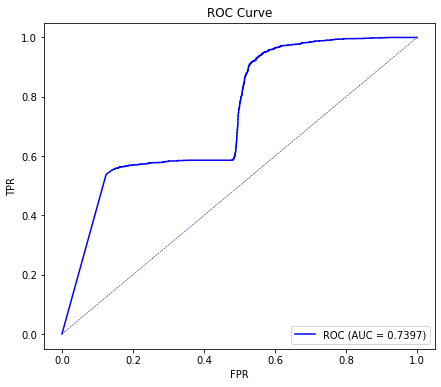

Detector ROC-AUC score: 0.73969


In [27]:
## Evaluate detector
# Compute logistic regression model predictions
probs = lr.predict_proba(values)[:, 1]
# Compute AUC
n_samples = len(X_test)

fpr, tpr, auc_score = compute_roc(
    probs_neg=probs[:n_samples],
    probs_pos=probs[n_samples:],
    labels=labels
)
print('Detector ROC-AUC score: %0.5f' % auc_score)